Artystyczny Transfer Stylu

Temat polega na implementacji algorytmu transferu stylu artystycznego na zdjęcia wykorzystując metody przetwarzania obrazów. Efektem może być na przykład metoda modyfikacji zdjęć tak aby przypominały styl konkretnego znanego malarza albo przerabianie klatek filmów na komiks

In [1]:
# !pip install tensorflow
# !pip install matplotlib
# !pip install numpy
!pip install tensorflow_hub
#jak ma problem z pakietami to tą komórkę odpalić, jupyter może nie mieć zainstalowanych modułów mimo tego, że na kompie normalnie są

In [84]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [85]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [86]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [110]:
from pathlib import Path
#generic pies
#content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
#style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

#moje fotki, sami musicie sobie path ustawić
#content_path = r'C:\Users\jacek\OneDrive\Pulpit\studyja\2st\3sem\artistic-style-transfer\imgs\500_F_139696027_EFLchVwpe8slFsnrzPtjWolLLCPXwd41.jpg'

# spoko

#style_path = Path("../imgs/costam.jpg")
style_path = Path("../imgs/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg")

content_path = Path('../imgs/freja.jpg')

In [111]:
content_path

WindowsPath('../imgs/freja.jpg')

In [89]:
def load_img(path_to_img):
  max_dim = 512

  img = tf.io.read_file(str(path_to_img))
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [90]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

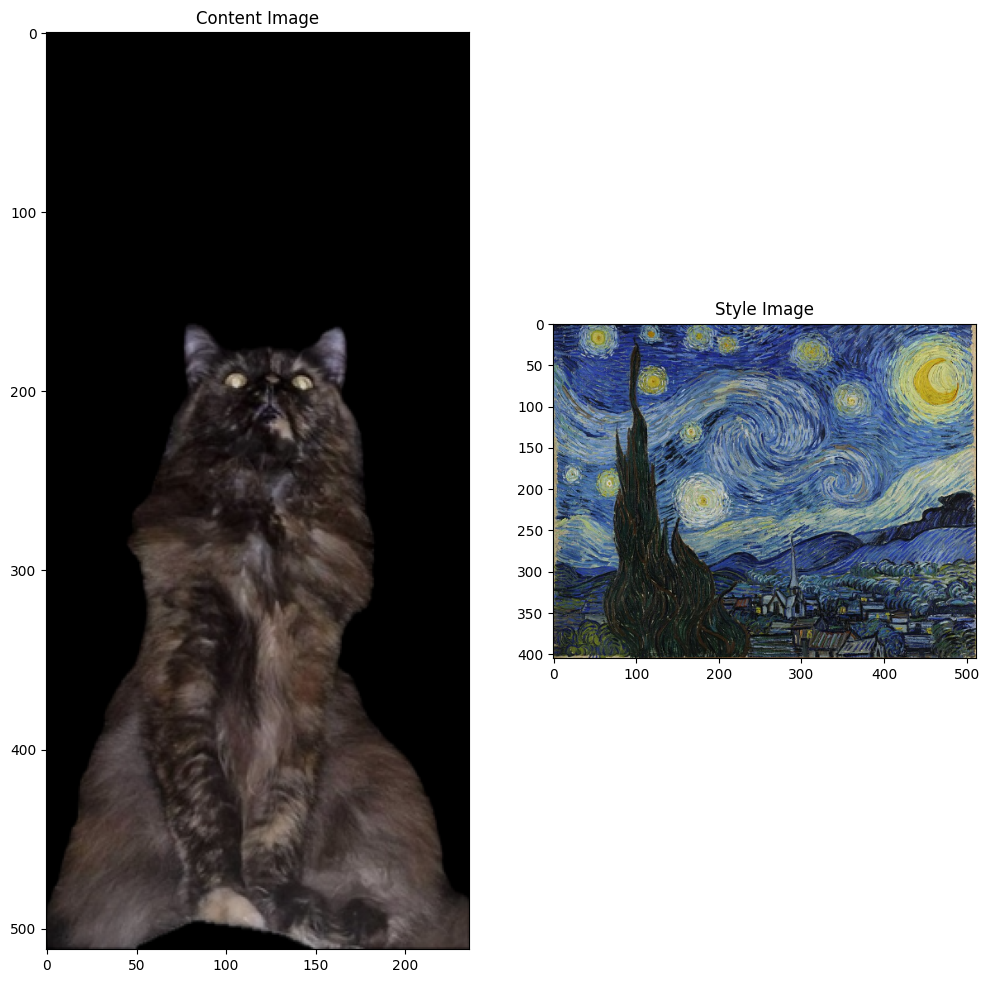

In [112]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

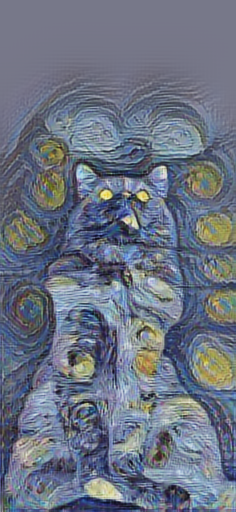

In [113]:
import tensorflow_hub as hub    #tutaj sam hub robi
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

In [114]:
#teraz "nasz" algorytm - vgg19 to rodzaj sieci, imo można potem popróbować z różnymi
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [120]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0] #rozpoznaje co na zdjeciu z psiakiem
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('Egyptian_cat', 0.052157104),
 ('Chesapeake_Bay_retriever', 0.04467541),
 ('plastic_bag', 0.032705978),
 ('cocker_spaniel', 0.02983213),
 ('tabby', 0.02894282)]

In [121]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet') #wypisuje warstwy jakie mamy

print()
for layer in vgg.layers:
  print(layer.name)


input_layer_10
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [122]:
content_layers = ['block5_conv2'] #ustawia te ktore chcemy uzyc

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [123]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [124]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

C:\Users\blaug\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_254']
Received: inputs=Tensor(shape=(1, 405, 512, 3))
  warnings.warn(msg)


block1_conv1
  shape:  (1, 405, 512, 64)
  min:  0.0
  max:  664.6659
  mean:  24.245178

block2_conv1
  shape:  (1, 202, 256, 128)
  min:  0.0
  max:  3028.075
  mean:  150.97714

block3_conv1
  shape:  (1, 101, 128, 256)
  min:  0.0
  max:  7665.912
  mean:  147.01529

block4_conv1
  shape:  (1, 50, 64, 512)
  min:  0.0
  max:  16845.44
  mean:  565.8336

block5_conv1
  shape:  (1, 25, 32, 512)
  min:  0.0
  max:  3924.2998
  mean:  48.63799



In [125]:
def gram_matrix(input_tensor): #funkcja obliczajaca styl jako macierz Grama, bardzo brzydki wzór na to jest. ok
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations) #SĄ DWIE MACIERZE GRAMA, STYLU I POTEM JEST MACIERZ WYGENEROWANEGO OBRAZU -> MOŻNA JE PRZEDSTAWIĆ JAKO MAPĘ CIEPŁA I PORÓWNAĆ FAJNIE
                                #MOZNA TEZ ZAPISAC JAKIES W TRAKCIE NAUKI, TAKI PROGRESS POKAZAĆ

In [128]:
class StyleContentModel(tf.keras.models.Model): #model zwracający tensor ze stylem i z treścią
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [129]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image)) #macierze grama ze stylem + zawartość warstw

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

C:\Users\blaug\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_276']
Received: inputs=Tensor(shape=(1, 512, 236, 3))
  warnings.warn(msg)


Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.00039603643
    max:  63312.035
    mean:  498.44104

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  55171.11
    mean:  11145.161

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  408308.75
    mean:  7819.9277

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  2947587.2
    mean:  147207.17

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  69259.04
    mean:  791.5831

Contents:
   block5_conv2
    shape:  (1, 32, 14, 512)
    min:  0.0
    max:  1190.5186
    mean:  9.389289


In [130]:
style_targets = extractor(style_image)['style'] #bo generalnie to obliczamy stratę obraz - styl jako błąd średniokwadratowy i chcemy zminimalizować to
content_targets = extractor(content_image)['content']

C:\Users\blaug\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_276']
Received: inputs=Tensor(shape=(1, 405, 512, 3))
  warnings.warn(msg)


In [194]:
image = tf.Variable(content_image) #obraz do optymalizacji - stylowania #PRZED KAŻDYM TRENOWANIEM RESET

In [104]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0) # normalizuje piksele na 0-1

In [132]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1) #optymalizator, polacaja adam albo lbfgs

In [193]:
style_weight=100
content_weight=1

In [134]:
def style_content_loss(outputs):    #daje stratę obraz - styl
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss    #TUTAJ BARTKU RÓŻNE PARAMETRY MOŻNA USTAWIAĆ, ŻEBY ZOBACZYĆ JAKIE EFEKTY DAJE - np style_loss*0.6 + content_loss*0.4
    return loss

In [135]:
@tf.function()
def train_step(image): #aktualizacja obrazu -> nałożenie stylu
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))
  return loss

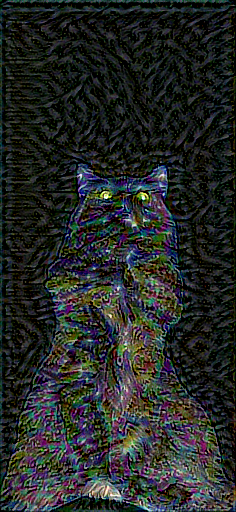

In [190]:
train_step(image)   #test czy działa - im więcej stepów tym bardziej styl nałożony

tensor_to_image(image)

In [137]:
from PIL import Image
def save_image(tensor, epoch):
    image_pil = tensor_to_image(tensor)
    image_pil.save(f"obraz_epoka_{epoch}.jpg")

Train step: 500 | Epoka: 50/50
Średnia wartość Grama (block1_conv1) – epoka 50: 733.1777


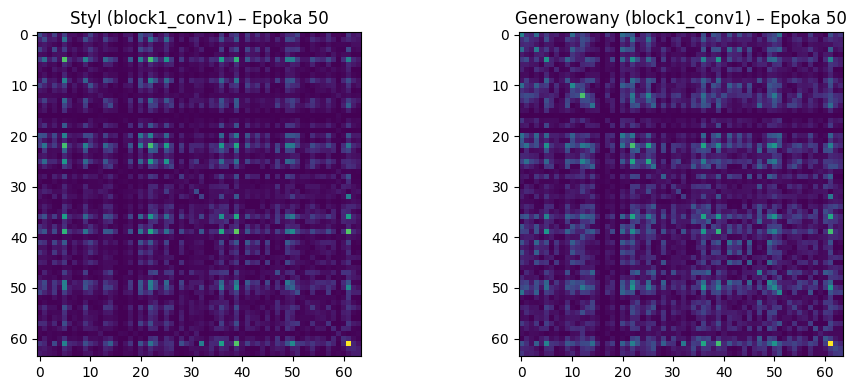

Średnia wartość Grama (block2_conv1) – epoka 50: 22703.61


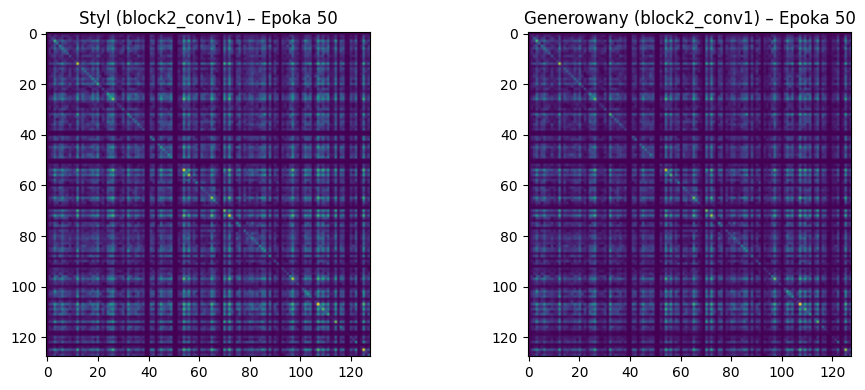

Średnia wartość Grama (block3_conv1) – epoka 50: 20515.771


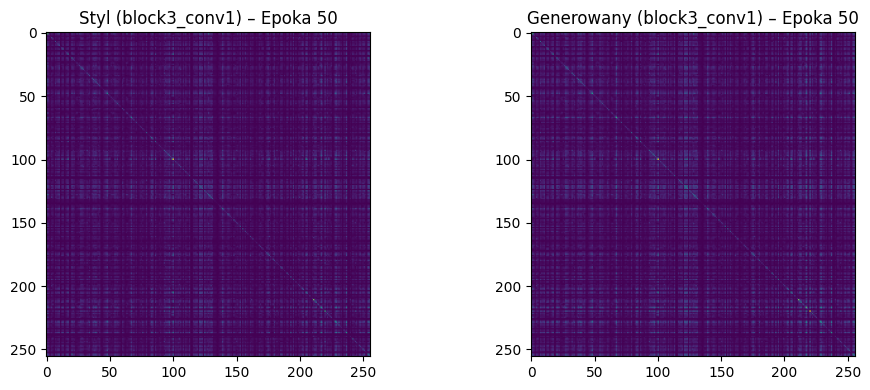

Średnia wartość Grama (block4_conv1) – epoka 50: 285829.25


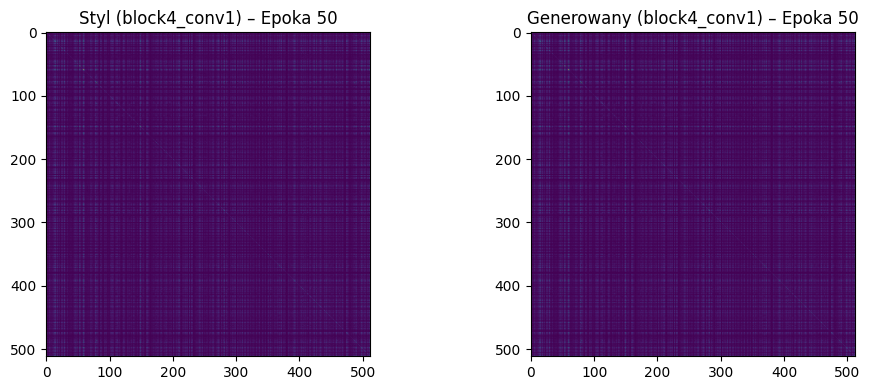

Średnia wartość Grama (block5_conv1) – epoka 50: 1708.434


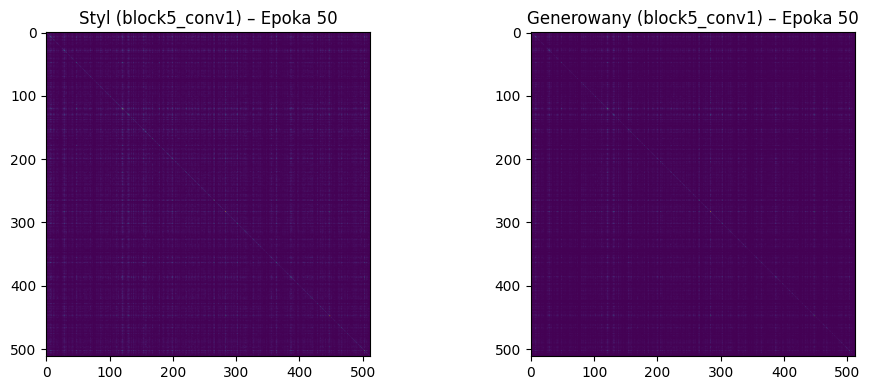

In [195]:
import time
import matplotlib.pyplot as plt

start = time.time()

epochs = 50
steps_per_epoch = 10
step = 0
loss_arr = []

# Lista warstw stylu
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        loss = train_step(image)
        loss_arr.append(loss.numpy())
        #train_step(image)
        print(".", end='', flush=True)

    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print(f"Train step: {step} | Epoka: {n+1}/{epochs}")

    # ### HEATMAPY CO 10 EPOK ### #
    if (n + 1) % 10 == 0:
        save_image(image,n)

        final_outputs = extractor(image)
        final_style = final_outputs['style']

        for layer in style_layers:
            print(f"Średnia wartość Grama ({layer}) – epoka {n+1}:", tf.reduce_mean(final_style[layer]).numpy())

            plt.figure(figsize=(10, 4))

            plt.subplot(1, 2, 1)
            plt.imshow(style_targets[layer][0], cmap='viridis')
            plt.title(f"Styl ({layer}) – Epoka {n+1}")

            plt.subplot(1, 2, 2)
            plt.imshow(final_style[layer][0], cmap='viridis')
            plt.title(f"Generowany ({layer}) – Epoka {n+1}")

            plt.tight_layout()

            plt.savefig(f"./heatmaps/epoka_{n+1}_{layer}.png")  # opcjonalnie: zapisz
            plt.show()

In [140]:
loss_arr

[2943818100000.0,
 1957864900000.0,
 1285269100000.0,
 795700560000.0,
 635161600000.0,
 583135700000.0,
 539848280000.0,
 471943680000.0,
 403917670000.0,
 343811700000.0,
 297274900000.0,
 262845460000.0,
 236883000000.0,
 216657690000.0,
 200585890000.0,
 187601300000.0,
 177176230000.0,
 169249550000.0,
 163319380000.0,
 158515180000.0,
 153942600000.0,
 149098500000.0,
 144094610000.0,
 139172230000.0,
 134459740000.0,
 129977640000.0,
 125696240000.0,
 121756615000.0,
 118356560000.0,
 115516326000.0,
 113164230000.0,
 111042570000.0,
 109037690000.0,
 107108320000.0,
 105175654000.0,
 103249215000.0,
 101320730000.0,
 99433490000.0,
 97556900000.0,
 95743150000.0,
 93993860000.0,
 92329040000.0,
 90698580000.0,
 89120440000.0,
 87601594000.0,
 86112080000.0,
 84675760000.0,
 83299746000.0,
 81979820000.0,
 80718316000.0,
 79513930000.0,
 78390570000.0,
 77322700000.0,
 76305020000.0,
 75322680000.0,
 74374260000.0,
 73440120000.0,
 72532350000.0,
 71655450000.0,
 70809780000.0,


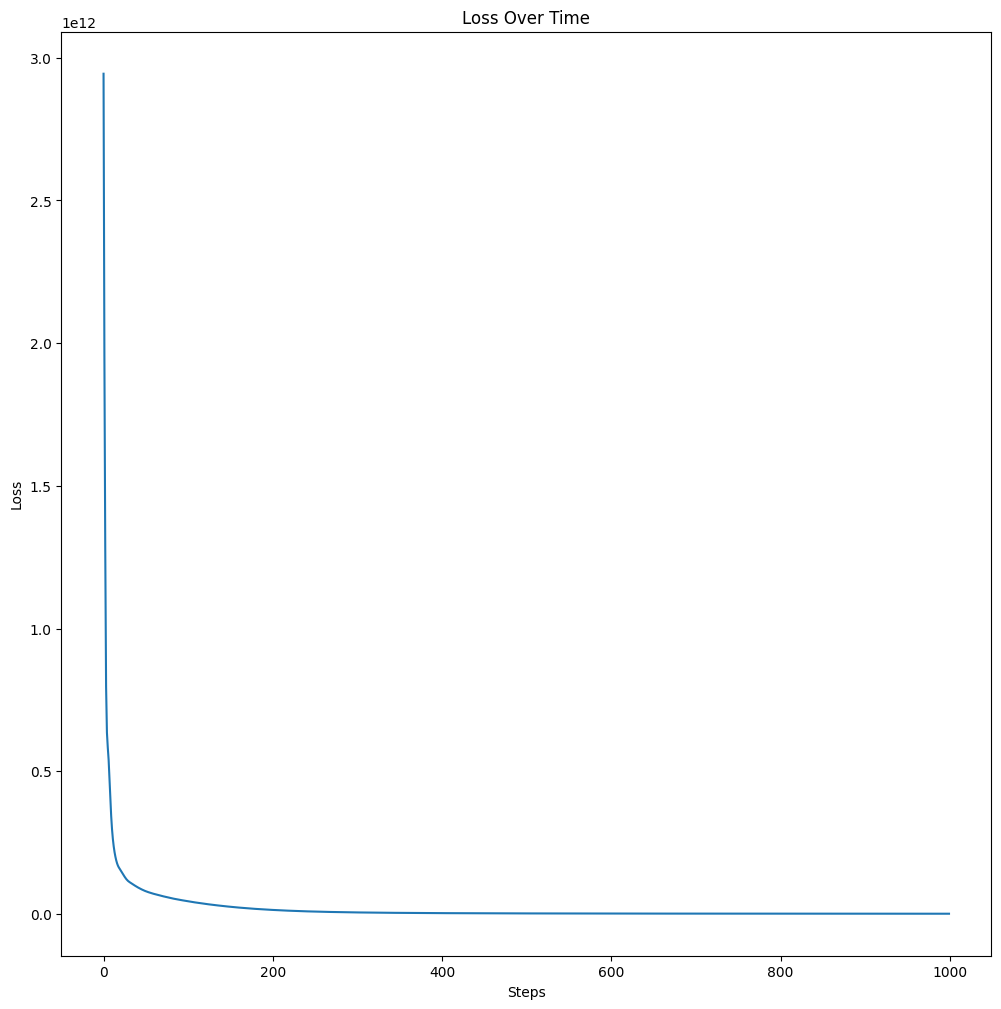

In [139]:
plt.plot(loss_arr[:1000])
plt.title("Loss Over Time")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.show()

### UWAGA - to zapisuje obrazek co epoke, wiec albo se to zakomentuj albo zrób mało epok bo Cie zmiecie z planszy


In [36]:
import time         #teraz robi optymalizację dłużej, dając obraz końcowy - ten co przy tf hubie, ale trochę rozpikselizowany cn.
start = time.time() #długo się robi dość, ale to można zmniejszyć ilość epok / stepów na epokę

epochs = 10
steps_per_epoch = 10
loss_arr = []
step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    loss = train_step(image)
    loss_arr.append(loss.numpy())
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))
  #save_image(image,n) #O tu jest zapisywanie obrazka

save_image(image,epochs)
end = time.time()
print("Total time: {:.1f}".format(end-start))

Train step: 100
Total time: 86.4


In [30]:
loss_arr

[np.float32(671347500.0),
 np.float32(509824300.0),
 np.float32(402889800.0),
 np.float32(336148770.0),
 np.float32(300430400.0),
 np.float32(280174270.0),
 np.float32(262413070.0),
 np.float32(244547380.0),
 np.float32(227734100.0),
 np.float32(212860240.0),
 np.float32(199721580.0),
 np.float32(188303970.0),
 np.float32(178616370.0),
 np.float32(170582100.0),
 np.float32(163901180.0),
 np.float32(158133460.0),
 np.float32(152816060.0),
 np.float32(147653570.0),
 np.float32(142580180.0),
 np.float32(137687740.0),
 np.float32(132974250.0),
 np.float32(128501300.0),
 np.float32(124196480.0),
 np.float32(120046100.0),
 np.float32(116063910.0),
 np.float32(112277416.0),
 np.float32(108700056.0),
 np.float32(105356480.0),
 np.float32(102198890.0),
 np.float32(99240776.0),
 np.float32(96444420.0),
 np.float32(93791630.0),
 np.float32(91325390.0),
 np.float32(89045960.0),
 np.float32(86958264.0),
 np.float32(85037610.0),
 np.float32(83272820.0),
 np.float32(81636500.0),
 np.float32(80122170.

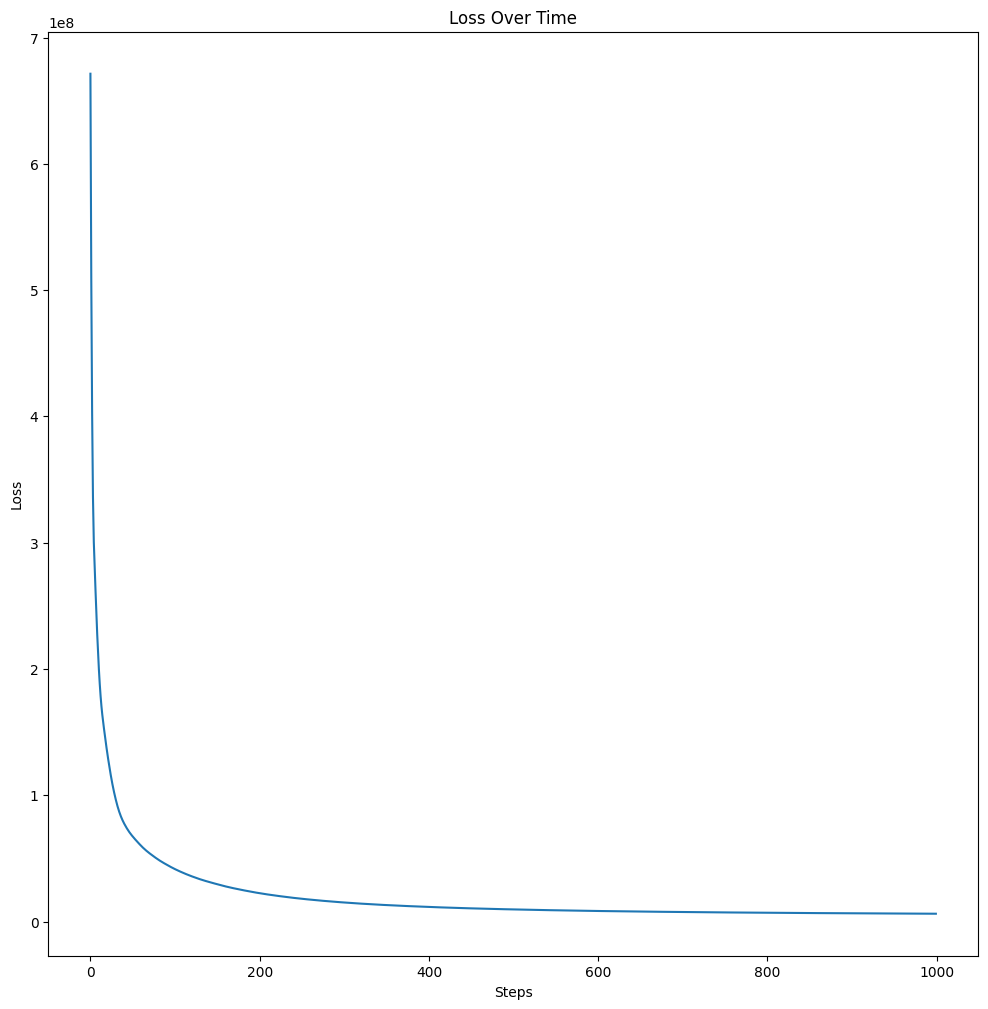

In [44]:
plt.plot(loss_arr[:1000])
plt.title("Loss Over Time")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.show()

In [32]:
def high_pass_x_y(image):   #tutaj robimy tak, że usuwamy duże częstotliwości z obrazu
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

  return x_var, y_var

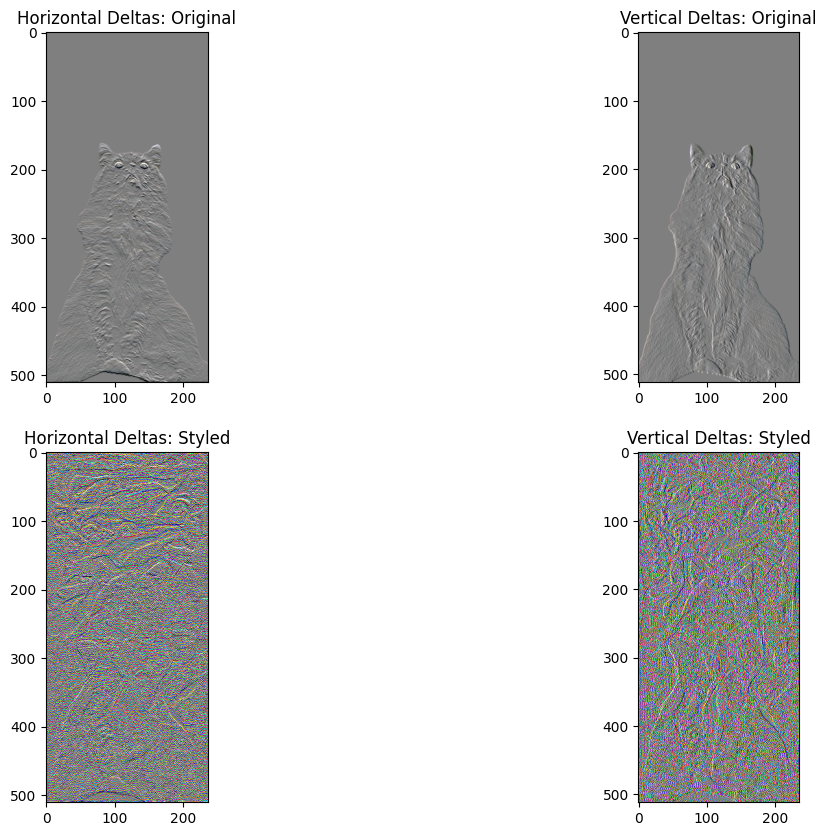

In [33]:
x_deltas, y_deltas = high_pass_x_y(content_image)   #tu widać te częstotliwości, not cool generalnie

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2, 2, 2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2, 2, 3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2, 2, 4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

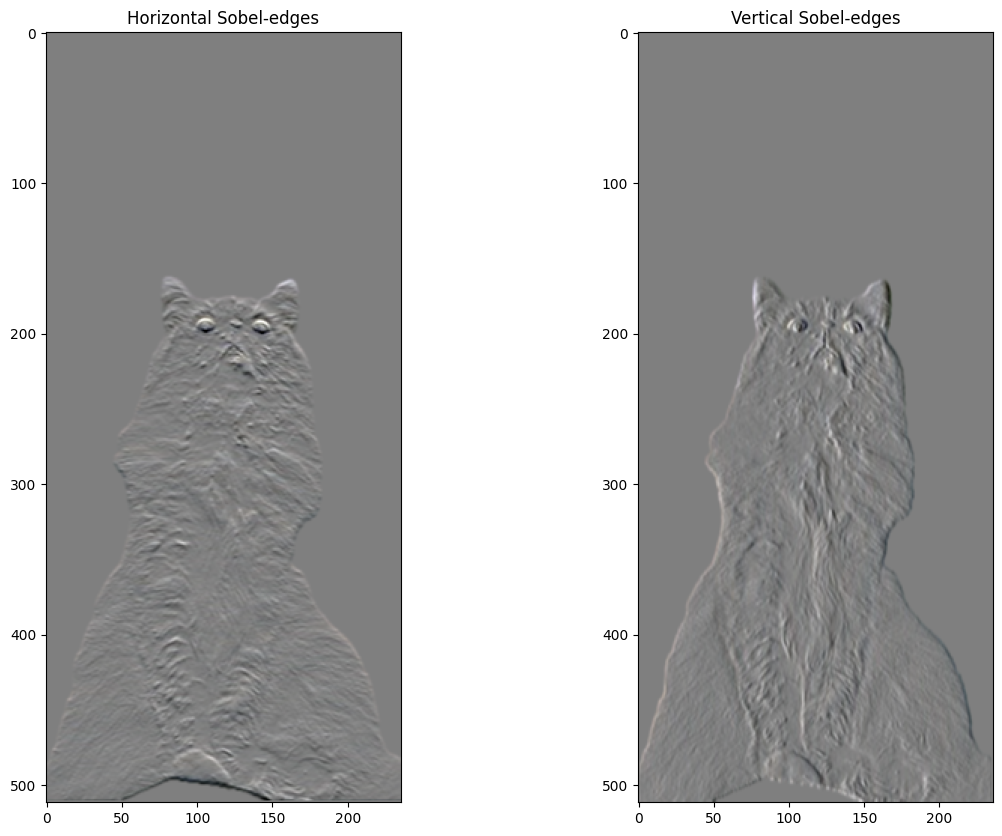

In [34]:
plt.figure(figsize=(14, 10))    #filtr sobela też da info o krawędziach

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1, 2, 1)
imshow(clip_0_1(sobel[..., 0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1, 2, 2)
imshow(clip_0_1(sobel[..., 1]/4+0.5), "Vertical Sobel-edges")

In [35]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [36]:
total_variation_loss(image).numpy()

np.float32(227748.12)

In [37]:
tf.image.total_variation(image).numpy()

array([227748.12], dtype=float32)

In [38]:
total_variation_weight=30 #na nowo optymalizuje

In [39]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02)  #dodać trzeba było, bo inaczej krzyczy że reusujemy optimizer- tego nie można robić xd


@tf.function()  #teraz trening bierze pod uwagę też te częstotliwości
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [40]:
image = tf.Variable(content_image)

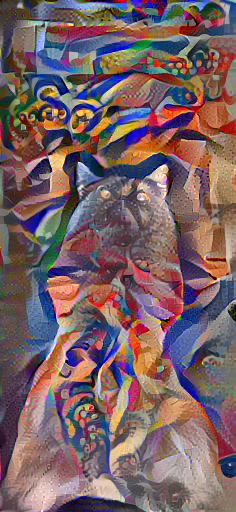

Train step: 5000
Total time: 2514.8


In [41]:
import time #pełniejszy obraz wychodzi, generalnie ładniej
start = time.time()

epochs = 50
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

In [42]:
file_name = 'stylized-image.png'
tensor_to_image(image).save(file_name)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)